In [1]:
%run 'pymol_and_pdb_functions.py'
start_pymol()

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


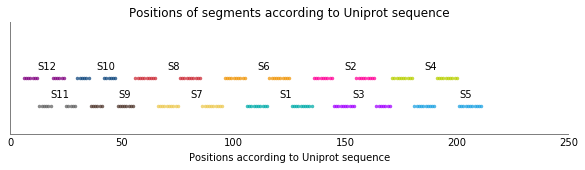

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


In [2]:
import itertools

%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks17'
image_counter = Counter()

### Reading 24-mer structure

In [3]:
his3_aligned_to_4lom_assembly_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', 
                                                  'his3_swiss_aligned_to_4lom_assembly.pdb')
structure = Bio.PDB.PDBParser().get_structure('his3_swiss_assembly', his3_aligned_to_4lom_assembly_file)
model = structure[0]

/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 37657.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 37675.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 37693.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 37711.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 37729.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructi

### Calculating distances

In [4]:
distance_dict = OrderedDict()
prefix = 'res_'

constant_chain = model['A']
positions_in_crystal = [r.id[1] for r in constant_chain.get_residues() if r.get_resname() in aa3]

f = FloatProgress(min=0, max=len(list(constant_chain.get_residues())))
display(f)

for residue in constant_chain.get_residues():
    if residue.get_resname() in aa3:
        distance_dict[prefix + '%s' %residue.id[1]] = OrderedDict()

        # distances to other residues
        for position in positions_in_crystal:
            distances = []
            for other_chain in model.get_chains():
                distances.append(get_distance_between_residues(residue, other_chain[position]))
            distance_dict[prefix + '%s' %residue.id[1]][prefix + '%s' %position] = min(distances)

        # distances to Mn ions
        for position in [302, 303, 304]:
            distances = []
            for other_chain in model.get_chains():
                other_residue = [r for r in other_chain if position == r.id[1]][0]
                distances.append(get_distance_between_residues(residue, other_residue))
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '%s' %position] = min(distances)
        distance_dict[prefix + '%s' %residue.id[1]]['Mn_substrate_bound'] = min(
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '302'],
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '303'])
            
        # distances to substrate
        for position in [301]:
            distances = []
            for other_chain in model.get_chains():
                other_residue = [r for r in other_chain if position == r.id[1]][0]
                distances.append(get_distance_between_residues(residue, other_residue))
            distance_dict[prefix + '%s' %residue.id[1]]['substrate'] = min(distances)
    f.value += 1

In [5]:
structural_data = pd.DataFrame.from_dict(distance_dict, orient='index')
new_index = sorted(structural_data.index.values, key=lambda s: int(s[4:]))
structural_data = structural_data.reindex(new_index)
structural_data['position'] = structural_data.index.map(lambda s: int(s[4:]))

### Secondary structure

In [6]:
# information from PyMol? using psico?
# import psico
# import psico.fullinit
# import psico.helping
# psico.helping.write_html_ref('psico-commands.html')

helices = range (60,74) + range (89,109) + range (157,172) + range (185,205)
sheets = range(5,12) + range(15,23) + range(52,55) + range(76,84) + range(117,125) + range(127,135) + range(138,145) + range(173,182)
disordered = [position for position in range(1, len(Scer_Uniprot)) if position not in helices and position not in sheets]

def get_secondary_structure(position):
#     print position, position in helices, position in sheets
    assert ~(position in helices and position in sheets)
    if position in helices:
        return 'helix'
    elif position in sheets:
        return 'sheet'
    else:
        return 'disordered'

structural_data['secondary_structure'] = structural_data['position'].apply(get_secondary_structure)

### Interface residues

In [7]:
ascii_letters_upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

cmd.reinitialize()
cmd.load(his3_aligned_to_4lom_assembly_file, 'his3_swiss_assembly')

interfaces = {}
f = FloatProgress(min=0, max=len(list(itertools.combinations(range(24), 2))))
display(f)
for chain_index1, chain_index2 in (itertools.combinations(range(24), 2)):
    chain1, chain2 = ascii_letters_upper[chain_index1], ascii_letters_upper[chain_index2]
    returned = interfaceResidues('his3_swiss_assembly', cA = 'c. %s' %chain1, cB = 'c. %s' %chain2)
    interfaces[chain1, chain2] = returned
    f.value += 1
    
interface_residues = []
for k,v in interfaces.items():
    interface_residues.extend([e[1] for e in v])
interface_residues = sorted(list(set([int(p) for p in interface_residues])))

structural_data['interface'] = structural_data.index.map(lambda s: int(s[4:]) in interface_residues)

### Sign epistasis from Lucas

In [8]:
# Relative >>> absolute position
position_translation = pd.read_table(files_dump_folder + 'position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

def get_absolute_position(segment_number, relative_position):
    return int(position_translation.iloc[relative_position]['S'+str(segment_number)])

In [9]:
lucas_sign_epistasis = pd.read_csv(files_dump_folder + 'sign_epistasis/' + 'lucas_sign_epistasis.csv')
lucas_reciprocal_sign_epistasis = pd.read_csv(files_dump_folder + 'sign_epistasis/' + 'lucas_reciprocal_sign_epistasis.csv')

p_value_threshold = 0.01
filtered = lucas_sign_epistasis[lucas_sign_epistasis['pBon'] < p_value_threshold]
sign_epistasis_positions = set.union(set(filtered['VarPos_absolute'].values), 
                                                set(filtered['SubPos_absolute'].values))
sign_epistasis_positions = sorted([int(s) for s in sign_epistasis_positions])
print len(sign_epistasis_positions), 'positions under sign epistasis'

reciprocal_sign_epistasis_positions = set.union(set(lucas_reciprocal_sign_epistasis['position1'].values), 
                                                set(lucas_reciprocal_sign_epistasis['position1'].values))
reciprocal_sign_epistasis_positions = sorted([int(s) for s in reciprocal_sign_epistasis_positions])
print len(reciprocal_sign_epistasis_positions), 'positions under reciprocal sign epistasis'

structural_data['lucas_sign_epistasis'] = structural_data.index.map(lambda s: int(s[4:]) in sign_epistasis_positions)
structural_data['lucas_reciprocal_sign_epistasis'] = structural_data.index.map(lambda s: int(s[4:]) in reciprocal_sign_epistasis_positions)

94 positions under sign epistasis
59 positions under reciprocal sign epistasis


### Conservation score

In [10]:
Scer_Uniprot = open(os.path.join(files_dump_folder, 'HIS3_saccharomyces_cerevisiae_from_Uniprot_P06633.txt')).read().rstrip()

# numbering starts from zero
conservation_scores = pd.read_table(files_dump_folder + 'conservation_score.csv')
conservation_scores['positions_Uniprot_P06633'] = conservation_scores.position_in_alignment.apply(
    lambda p: get_wt_position(p))

structural_data['segment'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['segment'])
structural_data['Scer_aa'] = structural_data['position'].apply(lambda p: Scer_Uniprot[p-1])

structural_data['alignment_entropy'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['entropy'])
structural_data['alignment_gap_fraction'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['gap_fr'])
structural_data['conservation_score'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['score'])

### Amino acid properties

In [11]:
aa_properties = pd.read_csv(files_dump_folder + 'properties_of_amino_acids.csv')
structural_data = structural_data.reset_index().merge(aa_properties, left_on='Scer_aa' ,right_on='aa1', how='left').set_index('index')

### Impacts of mutations

In [12]:
def read_impacts_in_all_backgrounds(path_to_folder=None):
    if not path_to_folder:
        path_to_folder = os.path.join(files_dump_folder, 'impacts_of_mutations_in_all_backgrounds__full_lib', '')
        print 'Since path to folder with hdfs was not provided, this is the path that will be used:\n%s' %path_to_folder

    f = FloatProgress(min=0, max=len(data.keys())
    display(f)

    fit_dict = OrderedDict()
    for segment in data:
        segment_folder = os.path.join(path_to_folder, segment.split('_')[0], '')
        files = [f for f in os.listdir(segment_folder)]
        data_subset = data[segment].copy() 
        mutations = list(set(':'.join(data_subset.dropna(subset=['mut_list_Scer']).mut_list_Scer.values).split(':')))
        mutations = sorted(list(mutations), key=lambda m: int(m[:-1]))
        for mutation in mutations:
            fn = 'impacts_of_mutation_%s.hdf' %(mutation)
            if fn in files:
                fit_dict[get_full_mutation(mutation)] = pd.read_hdf(segment_folder + fn)
        f.value += 1
    return fit_dict

folder_with_fitness_impacts = check_dir(os.path.join(files_dump_folder, 'impacts_of_mutations_in_all_backgrounds', ''))
fit_dict = read_impacts_in_all_backgrounds(path_to_folder=folder_with_fitness_impacts)

SyntaxError: invalid syntax (<ipython-input-12-cd711a57207c>, line 7)

In [ ]:
fitness_impacts = pd.DataFrame.from_dict(fit_dict, orient='index')
fitness_impacts['position'] = fitness_impacts.index.map(lambda s: int(s[1:-1]))
fitness_impacts['impact_mean'] = fitness_impacts.index.map(lambda m: fitness_impacts.loc[m].dropna().mean())
fitness_impacts['impact_median'] = fitness_impacts.index.map(lambda m: fitness_impacts.loc[m].dropna().median())
fitness_impacts['impact_std'] = fitness_impacts.index.map(lambda m: fitness_impacts.loc[m].dropna().std())

In [ ]:
impacts_summary = fitness_impacts.groupby('position')['impact_median'].agg([np.mean, np.median, np.std])
impacts_summary.columns = ['impact_' + s for s in impacts_summary.columns]
structural_data = structural_data.reset_index().merge(impacts_summary, how='left', left_on='position', right_index=True)
structural_data = structural_data.set_index('index')

### Epistasis

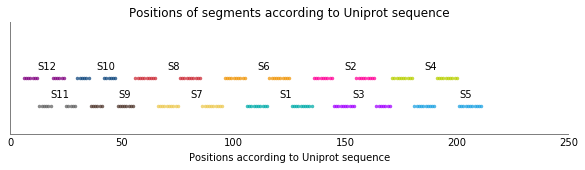

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


In [18]:
%run 'ks08_Epistasis_in_all_backgrounds.ipynb'

In [82]:
def get_empty_segment_position1_position2_defaultdict(segment_mutA_mutB_dict):
    epistasis_by_positions = OrderedDict()
    for segment in segment_mutA_mutB_dict:
#         epistasis_by_positions[segment] = OrderedDict()
        mutA_positions = set(mutA[:-1] for mutA, mutB in segment_mutA_mutB_dict[segment])
        mutB_positions = set(mutB[:-1] for mutA, mutB in segment_mutA_mutB_dict[segment])
        all_positions = sorted(list(set.union(mutA_positions, mutB_positions)), key=lambda s: int(s))
        for position1 in all_positions:
            epistasis_by_positions[position1] = OrderedDict()
            for position2 in all_positions:
                if position1 != position2:
                    epistasis_by_positions[position1][position2] = defaultdict(list)
    return epistasis_by_positions

def fill_dictionary_with_values(dict_to_fill, segment_mutA_mutB_dict):
    for segment in segment_mutA_mutB_dict:
        for mutA, mutB in segment_mutA_mutB_dict[segment]:
            posA, posB = mutA[:-1], mutB[:-1]
            ep = segment_mutA_mutB_dict[segment][mutA, mutB]

            if len(ep) > minimal_N:    
                std = ep.std()
                mean = ep.mean()
                median = ep.median()
                fraction_strong = 1. * len(ep[np.abs(ep) > strong_epistasis_threshold]) / len(ep)

                dict_to_fill[posA][posB]['std'].append(std)
                dict_to_fill[posB][posA]['std'].append(std)
                
                dict_to_fill[posA][posB]['mean'].append(mean)
                dict_to_fill[posB][posA]['mean'].append(mean)

                dict_to_fill[posA][posB]['median'].append(median)
                dict_to_fill[posB][posA]['median'].append(median)

                dict_to_fill[posA][posB]['fraction_strong'].append(fraction_strong)
                dict_to_fill[posB][posA]['fraction_strong'].append(fraction_strong)
                
    return dict_to_fill

def filter_position1_position2_dict(position1_position2_dict, what_to_look_at):
    filtered = {}
    for position in position1_position2_dict:
        other_positions = position1_position2_dict[position].keys()
        other_positions = [p for p in other_positions if len(position1_position2_dict[position][p][what_to_look_at]) > 0]
        values = [np.mean(position1_position2_dict[position][p][what_to_look_at]) for p in other_positions \
                  if len(position1_position2_dict[position][p][what_to_look_at]) > 0]
        filtered[position] = other_positions, values
    return filtered

In [86]:
epdict__pos1_pos2 = get_empty_segment_position1_position2_defaultdict(ep_dict)
epdict__pos1_pos2 = fill_dictionary_with_values(epdict__pos1_pos2, ep_dict)

In [118]:
ep_mean_prefix = 'ep_mean_res_'

def get_ep_slice(dict__pos1_pos2, function, ep_prefix):
    d = {}
    for position1 in dict__pos1_pos2:
        for position2 in dict__pos1_pos2[position1]:
            d[prefix + '%s' %position1] = {}
            d[prefix + '%s' %position2] = {}

    for position1 in dict__pos1_pos2:
        for position2 in dict__pos1_pos2[position1]:
            d[prefix + '%s' %position1][ep_prefix + '%s' %position2] = function(dict__pos1_pos2[position1][position2]['median'])
            d[prefix + '%s' %position2][ep_prefix + '%s' %position1] = function(dict__pos1_pos2[position1][position2]['median'])
    df = pd.DataFrame.from_dict(d, orient='index')
    sorted_columns = sorted(df.columns, key=lambda s: int(s[len(ep_prefix):]))
    df['position'] = df.index.map(lambda s: int(s[len(prefix):]))
    return df

structural_data1 = structural_data.merge(get_ep_slice(epdict__pos1_pos2, np.mean, ep_mean_prefix), on='position', how='left')

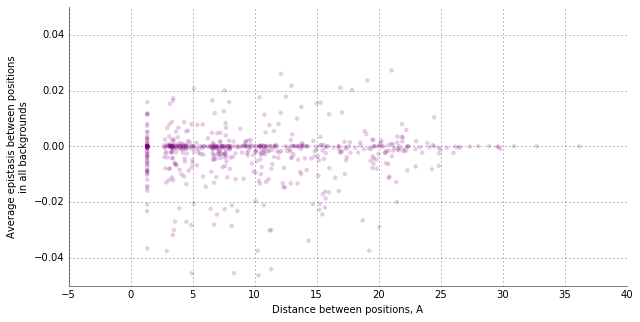

In [129]:
title = 'Distance vs epistasis'
plot_better()
for position in structural_data1['position']:
    try:
        plt.scatter(structural_data1[prefix + '%s' %position], structural_data1[ep_mean_prefix + '%s' %position], 
                    edgecolor='none', color='purple', alpha=0.1)
    except:
        pass
plt.ylim(-0.05, 0.05)
plt.xlabel('Distance between positions, A')
plt.ylabel('Average epistasis between positions\nin all backgrounds')

### Saving files

In [130]:
structural_data.to_hdf(files_dump_folder + 'structural_data_for_predicted_24mer.hdf', 'data')
structural_data.reset_index().to_csv(files_dump_folder + 'structural_data_for_predicted_24mer.csv', index=False)